In [2]:
ROOT_PATH = '../../../../'
UKBB_DATA_PATH = ROOT_PATH + 'assets/data/ukbb/'
BASE_LOG_PATH = ROOT_PATH + 'assets/models/ukbb/SVIExperiment'

import sys
import os

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import PIL as pl
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from collections import defaultdict
from functools import partial
from IPython.display import display, Image # to display images
from sklearn import cluster # for running K-means
from skimage.io import imread
import torch
from PIL import Image

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

from deepscm.datasets.medical.adni import ADNIDataset

data_dir = '/home/aay993/full_imputed_clinical_covariates.csv' # standard data path 
base_path = '/home/aay993/bias_corrected_registered_slices/' # standard img path 

# data_dir = '/home/aay993/val_patients_clinical_covariates.csv' # validation data path 
# base_path = '/home/aay993/validation_brains/slices' # validation img path 
downsample = 3
ukbb_test = ADNIDataset(data_dir, base_path=base_path, crop_type='center', downsample=downsample)

In [4]:

from deepscm.experiments.medical import ukbb  # noqa: F401
from deepscm.experiments.medical.base_experiment_adni import EXPERIMENT_REGISTRY, MODEL_REGISTRY

var_name = {'ventricle_volume': 'v', 
'brain_volume': 'b', 
'sex': 's', 'age': 'a',
'tau': 't', 'education': 'e', 'moca': 'm', 'av45': 'av'}
value_fmt = {
    'ventricle_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'brain_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{male}', '\mathrm{female}'][int(s)]),
    'tau': lambda s: rf'{float(s):.4}\,\mathrm{{pg/ml}}',
    'education': lambda s: rf'{int(s):d}\,\mathrm{{u}}',
    'moca': lambda s: rf'{int(s):d}\,\mathrm{{score}}',
    'av45': lambda s: rf'{float(s):.4}\,\mathrm{{mSUVR}}',
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ',\n'.join([f'${var_name[k]}={value_fmt[k](v)}$' for k, v in intervention.items()])
        return f"do({all_interventions})"

def prep_data(batch):
    x = 255. * batch['x'].float().unsqueeze(0)
    age = batch['age'].unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].unsqueeze(0).unsqueeze(0).float()
    ventricle_volume = batch['ventricle_volume'].unsqueeze(0).unsqueeze(0).float()
    brain_volume = batch['brain_volume'].unsqueeze(0).unsqueeze(0).float()
    moca = batch['moca'].unsqueeze(0).unsqueeze(0).float()
    education = batch['education'].unsqueeze(0).unsqueeze(0).float()
    tau = batch['tau'].unsqueeze(0).unsqueeze(0).float()
    av45 = batch['av45'].unsqueeze(0).unsqueeze(0).float()
    apoe = batch['APOE4'].unsqueeze(0).unsqueeze(0).float()
    slice_number = batch['slice_number'].unsqueeze(0).unsqueeze(0).float()
    return {'x': x, 'age': age, 'sex': sex, 'ventricle_volume': ventricle_volume,
            'brain_volume': brain_volume, 'education': education,
            'tau': tau, 'moca': moca, 'av45': av45, 'APOE4': apoe, 'slice_number': slice_number}
experiments = ['ConditionalVISEM']
models = {}
loaded_models = {}

for exp in experiments:
    try:
        # checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_0/'
        checkpoint_path = '/home/aay993/dscm/DSCM_implementation/SVIExperiment/ConditionalVISEM/version_117'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        # hparams = ckpt['hparams'] # previous function (for checkpoints already trained)
        hparams = ckpt['hyper_parameters'] # for newly trained model checkpoints 
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

In [5]:
def segment(img, k=2): 
    shape = img.shape
    img = img.reshape((-1, 1))
     # Define and run K-means 
    k_means = cluster.KMeans(n_clusters=k) 
    k_means.fit(img) 

    values = k_means.cluster_centers_.squeeze() 
    labels = k_means.labels_

    # Create an array from labels and values 
    img_data_seg = np.choose(labels, values)
    img_data_seg.shape = shape

    return len(np.argwhere(img_data_seg == np.unique(img_data_seg)[1])), img_data_seg

In [14]:
# Example of producing a large number of counterfactual inferences for a specific variable (age)
age_volumes_10 = [] 
age_volumes_20 = []
age_volumes_s_20 = [] 
model_name = 'ConditionalVISEM'
num_samples = 32
k = 2


for i in range(len(ukbb_test)):
    print(f'processing overall slice number {i}') 
    

    # Running counterfactuals
    orig_data = prep_data(ukbb_test[i])  


    pyro.clear_param_store()
    cond = {'age': torch.tensor([[ukbb_test[i]['age'] * 1.1]])}
    counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)
    counterfactual_img = counterfactual['x'].squeeze()

    age_volumes_10.append(segment(counterfactual_img)[0])

    pyro.clear_param_store()
    cond = {'age': torch.tensor([[ukbb_test[i]['age'] * 1.2]])}
    counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)
    counterfactual_img = counterfactual['x'].squeeze()

    age_volumes_20.append(segment(counterfactual_img)[0])

    pyro.clear_param_store()
    cond = {'age': torch.tensor([[ukbb_test[i]['age'] * 0.8]])}
    counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)
    counterfactual_img = counterfactual['x'].squeeze()

    age_volumes_s_20.append(segment(counterfactual_img)[0])

processing overall slice number 0
processing overall slice number 1
processing overall slice number 2
processing overall slice number 3
processing overall slice number 4
processing overall slice number 5
processing overall slice number 6
processing overall slice number 7
processing overall slice number 8
processing overall slice number 9
processing overall slice number 10
processing overall slice number 11
processing overall slice number 12
processing overall slice number 13
processing overall slice number 14
processing overall slice number 15
processing overall slice number 16
processing overall slice number 17
processing overall slice number 18
processing overall slice number 19
processing overall slice number 20
processing overall slice number 21
processing overall slice number 22
processing overall slice number 23
processing overall slice number 24
processing overall slice number 25
processing overall slice number 26
processing overall slice number 27
processing overall slice numbe

In [15]:
df_age = pd.DataFrame(data=list(zip(age_volumes_10, age_volumes_20, age_volumes_s_20)), columns=['+10%', '+20%', '-20%'])
df_age

,+10%,+20%,-20%
0,1714,1669,1728
1,1757,1727,1776
2,1753,1711,1760
3,1692,1671,1714
4,1626,1617,1644
...,...,...,...
2645,1450,1454,1510
2646,1422,1405,1464
2647,1402,1403,1438
2648,1392,1390,1429


In [17]:
df_age['Original masks'] = df['Original masks']
df_age

,+10%,+20%,-20%,Original masks
0,1714,1669,1728,1738
1,1757,1727,1776,1776
2,1753,1711,1760,1762
3,1692,1671,1714,1717
4,1626,1617,1644,1645
...,...,...,...,...
2645,1450,1454,1510,1458
2646,1422,1405,1464,1433
2647,1402,1403,1438,1403
2648,1392,1390,1429,1398


In [18]:
df_age.to_csv('age_brain_volume_seg_validations.csv')

1284
1386


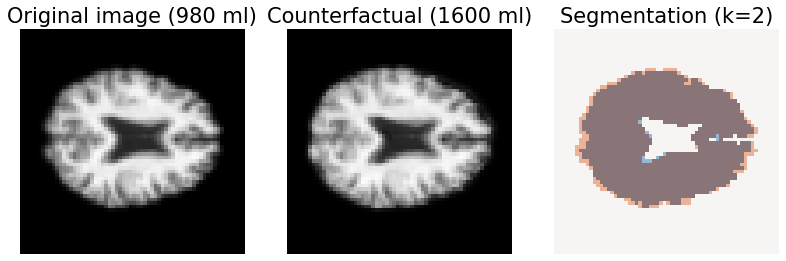

In [77]:
idx = 3
original_image = imread(f'original_{idx}.png')
counterfactual_image = imread(f'counterfactual_{idx}.png')


def segmentation_plot(imgs, num_clusters, img_title, save=False): 
 
    np.random.seed(0) 

    # segmentations 
    segmentations = {}

    for i in range(len(imgs)):
        # Reshape to a (n_sample, n_feature) array 
        X = imgs[i].reshape((-1, 1))

        # Define an run K-means
        k = num_clusters 
        k_means = cluster.KMeans(n_clusters=k)
        k_means.fit(X)

        values = k_means.cluster_centers_.squeeze()
        labels = k_means.labels_

        # Create an array from labels and values 
        segmentations[f'img_data_seg_{i}_{k}'] = np.choose(labels, values)
        segmentations[f'img_data_seg_{i}_{k}'].shape = imgs[0].shape
        # img_data_seg = np.choose(labels, values)
        # img_data_seg.shape = img.shape 
    

    vmin = imgs[0].min()
    vmax = imgs[0].max() 

    plt.figure(figsize=(15, 7))
    cmaps = ['Blues', 'Oranges']
    alphas = [.8, .4]
    ticker = 1

    for i in range(len(imgs)): 
        

        plt.subplot(len(imgs), 4, ticker)
        plt.imshow(imgs[i], cmap='gray', vmin=vmin, vmax=256)
        plt.axis('off')
        plt.title(img_title[i], size=21)
        plt.tight_layout() 
        ticker += 1

    for i in range(len(imgs)):    
        k = num_clusters 
        plt.subplot(len(imgs), 4, 3)
        plt.imshow(segmentations[f'img_data_seg_{i}_{k}'], cmap=cmaps[i], vmin=vmin, vmax=vmax,  alpha=alphas[i])
        plt.title(f'Segmentation (k={k})', size=21)
        plt.axis('off')
        plt.tight_layout()
        pixels, _ = segment(segmentations[f'img_data_seg_{i}_{k}'])
        print(pixels)
        
        
    
    if save: 
        plt.savefig('segmentation_single_participant.png', dpi=600, bbox_inches='tight')
    
    return segmentations

segmentations = segmentation_plot([original_image, counterfactual_image], 2, ['Original image (980 ml)', 'Counterfactual (1600 ml)'], save=True)

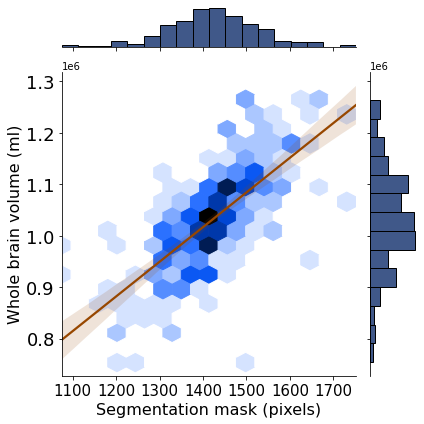

In [25]:
df = pd.read_csv('brain_volume_seg_validations.csv')
df_mean = df.groupby(np.arange(len(df))//10).mean()
sns.jointplot(x=df_mean['Original masks'], y=df_mean['FSL volumes'], kind='hex', color='#002061')
sns.regplot(x=df_mean['Original masks'], y=df_mean['FSL volumes'], color='#974700', marker='')
plt.xlabel('Segmentation mask (pixels)', size=16)
plt.ylabel('Whole brain volume (ml)', size=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('correlation_seg_mask_FSL_volume.png', dpi=600, bbox_inches='tight')

In [30]:
import scipy 
scipy.stats.pearsonr(df_mean['Original masks'], df_mean['FSL volumes']) # Calculate R value between the segmentation masks and the whole brain volume. 

(0.7050497814714984, 3.8642729212832247e-41)

In [6]:
def calculate_percentage(df, column): 
    variable = df[f'{column}'] 
    diff = variable - df['Original masks'] 
    percentage = (diff / df['Original masks']) * 100 
    return percentage

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-40% vs. NULL: Welch's t-test independent samples with Bonferroni correction, P_val:7.722e-64 t=-1.717e+01
NULL vs. +40%: Welch's t-test independent samples with Bonferroni correction, P_val:1.255e-35 t=-1.264e+01
NULL vs. +60%: Welch's t-test independent samples with Bonferroni correction, P_val:4.482e-74 t=-1.856e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-20% vs. NULL: Welch's t-test independent samples with Bonferroni correction, P_val:8.973e-01 t=1.038e+00
NULL vs. +10%: Welch's t-test independent samples with Bonferroni correction, P_val:4.520e-01 t=1.437e+00
NULL vs. +20%: Welch's t-test independent samples with Bonferroni correction, P_val:5.823e-04 t=3.729e+00

/home/aay993/python_envs_WSL/dscm/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/aay993/python_envs_WSL/dscm/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NULL vs. +100%: Welch's t-test independent samples with Bonferroni correction, P_val:1.869e-07 t=5.420e+00
NULL vs. +200%: Welch's t-test independent samples with Bonferroni correction, P_val:1.977e-25 t=1.058e+01


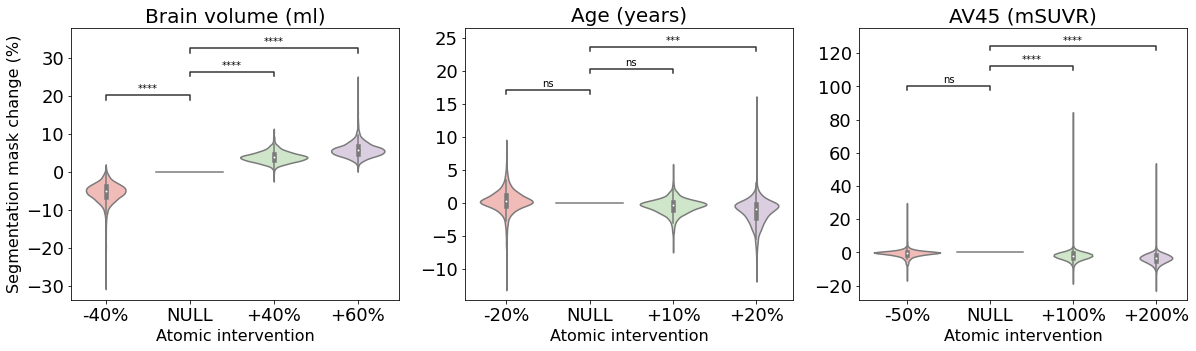

In [49]:

from statannotations.Annotator import Annotator
import statsmodels


# For the statistical testing
df_real = pd.read_csv('brain_volume_seg_validations.csv')

values = np.concatenate((
    df_real['-40%'].to_numpy(), 
    df_real['Original masks'].to_numpy(),
    df_real['+40%'].to_numpy(), 
    df_real['+60%'].to_numpy()))

df_real = pd.DataFrame(data=values, columns=['values'])
df_real['interventions'] = 0
df_real['interventions'].iloc[:2650] = '-40%'
df_real['interventions'].iloc[2650:2650*2] = 'NULL'
df_real['interventions'].iloc[2650*2:2650*3] = '+40%'
df_real['interventions'].iloc[2650*3:] = '+60%' 

df_real_age = pd.read_csv('age_brain_volume_seg_validations.csv')

values = np.concatenate((
    df_real_age['-20%'].to_numpy(), 
    df_real_age['Original masks'].to_numpy(),
    df_real_age['+10%'].to_numpy(), 
    df_real_age['+20%'].to_numpy()))

df_real_age = pd.DataFrame(data=values, columns=['values'])
df_real_age['interventions'] = 0
df_real_age['interventions'].iloc[:2650] = '-20%'
df_real_age['interventions'].iloc[2650:2650*2] = 'NULL'
df_real_age['interventions'].iloc[2650*2:2650*3] = '+10%'
df_real_age['interventions'].iloc[2650*3:] = '+20%' 

df_real_av45 = pd.read_csv('av45_brain_volume_seg_validations.csv')

values = np.concatenate((
    df_real_av45['-50%'].to_numpy(), 
    df_real_av45['Original masks'].to_numpy(),
    df_real_av45['+200%'].to_numpy(), 
    df_real_av45['+700%'].to_numpy()))

df_real_av45 = pd.DataFrame(data=values, columns=['values'])
df_real_av45['interventions'] = 0
df_real_av45['interventions'].iloc[:2650] = '-50%'
df_real_av45['interventions'].iloc[2650:2650*2] = 'NULL'
df_real_av45['interventions'].iloc[2650*2:2650*3] = '+100%'
df_real_av45['interventions'].iloc[2650*3:] = '+200%'


# For the plotting of percentage change
df = pd.read_csv('brain_volume_seg_validations.csv')
df_age = pd.read_csv('age_brain_volume_seg_validations.csv')
df_av45 = pd.read_csv('av45_brain_volume_seg_validations.csv')

# Converting dataframe to format compatiable with statannotations
values = np.concatenate((
    calculate_percentage(df, '-40%').to_numpy(), 
    calculate_percentage(df, 'Original masks').to_numpy(),
    calculate_percentage(df, '+40%').to_numpy(), 
    calculate_percentage(df, '+60%').to_numpy()))

df = pd.DataFrame(data=values, columns=['values'])
df['interventions'] = 0
df['interventions'].iloc[:2650] = '-40%'
df['interventions'].iloc[2650:2650*2] = 'NULL'
df['interventions'].iloc[2650*2:2650*3] = '+40%'
df['interventions'].iloc[2650*3:] = '+60%'

plt.figure(figsize=(20, 5))

# First plot 
plt.subplot(1, 3, 1)
plt.title('Brain volume (ml)', size=20)
ax = sns.violinplot(data=df, x='interventions', y='values', palette="Pastel1") 
plt.xlabel('Atomic intervention', size=16)
plt.ylabel('Segmentation mask change (%)', size=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

annot = Annotator(ax, [("-40%", "NULL"), ("+40%", "NULL"), ('+60%', 'NULL')], data=df_real, x='interventions', y='values')
annot.configure(test='t-test_welch', text_format='star', loc='inside', comparisons_correction="Bonferroni", verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.3, line_offset=0.1)

# Converting dataframe to format compatiable with statannotations
values = np.concatenate((
    calculate_percentage(df_age, '-20%').to_numpy(), 
    calculate_percentage(df_age, 'Original masks').to_numpy(),
    calculate_percentage(df_age, '+10%').to_numpy(), 
    calculate_percentage(df_age, '+20%').to_numpy()))

df_age = pd.DataFrame(data=values, columns=['values'])
df_age['interventions'] = 0
df_age['interventions'].iloc[:2650] = '-20%'
df_age['interventions'].iloc[2650:2650*2] = 'NULL'
df_age['interventions'].iloc[2650*2:2650*3] = '+10%'
df_age['interventions'].iloc[2650*3:] = '+20%'

# Second plot. 
plt.subplot(1, 3, 2)
plt.title('Age (years)', size=20)
ax = sns.violinplot(data=df_age, x='interventions', y='values', palette="Pastel1") 
plt.xlabel('Atomic intervention', size=16) 
plt.ylabel('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


annot = Annotator(ax, [("-20%", "NULL"), ("NULL", "+10%"), ('NULL', '+20%')], data=df_real_age, x='interventions', y='values')
annot.configure(test='t-test_welch', text_format='star', loc='inside', comparisons_correction="Bonferroni", verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.4, line_offset=0.1)

# Converting dataframe to format compatiable with statannotations
values = np.concatenate((
    calculate_percentage(df_av45, '-50%').to_numpy(), 
    calculate_percentage(df_av45, 'Original masks').to_numpy(),
    calculate_percentage(df_av45, '+200%').to_numpy(), 
    calculate_percentage(df_av45, '+700%').to_numpy()))

df_av45 = pd.DataFrame(data=values, columns=['values'])
df_av45['interventions'] = 0
df_av45['interventions'].iloc[:2650] = '-50%'
df_av45['interventions'].iloc[2650:2650*2] = 'NULL'
df_av45['interventions'].iloc[2650*2:2650*3] ='+100%'
df_av45['interventions'].iloc[2650*3:] = '+200%'

# Third plot. 
plt.subplot(1, 3, 3)
plt.title('AV45 (mSUVR)', size=20)
ax = sns.violinplot(data=df_av45, x='interventions', y='values', palette="Pastel1", inner='box') 
plt.xlabel('Atomic intervention', size=16) 
plt.ylabel('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

annot = Annotator(ax, [("-50%", "NULL"), ("NULL", "+100%"), ('NULL', '+200%')], data=df_real_av45, x='interventions', y='values')
annot.configure(test='t-test_welch', text_format='star', loc='inside', comparisons_correction="Bonferroni", verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.8, line_offset=0.1)


plt.savefig('statistical_testing_of_counterfactuals.png', dpi=900, bbox_inches='tight')


# plt.savefig('example_non-hue_inside.png', dpi=300, bbox_inches='tight')

In [138]:
import collections 
from collections import namedtuple
from scipy import special

def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = special.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [144]:
welch_anova_np(df_age['+10%'], df_age['+20%'], df_age['-20%'])

F_onewayResult(statistic=11.356681403355225, pvalue=1.1978393707402552e-05)

In [159]:
welch_anova_np(df['-40%'], df['+40%'], df['+60%'])

F_onewayResult(statistic=731.0436976886334, pvalue=4.255319595023352e-281)

In [160]:
welch_anova_np(df_av45['-50%'], df_av45['+200%'], df_av45['+700%'])

F_onewayResult(statistic=38.589872695253725, pvalue=2.2994320336663158e-17)